In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [8]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [9]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [10]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [11]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [12]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [13]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [14]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [15]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=1
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [16]:
def cifar_dirichlet(dataset, n_nets, alpha=0.5):
    '''
    if dataset == 'mnist':
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    '''
    #X_train=dataset[:][0]
    y_train=torch.zeros(len(dataset),dtype=torch.long)
    print(y_train.dtype)
    for a in range(len(dataset)):
        y_train[a]=(dataset[a][1])
    n_train = len(dataset)
    #X_train.shape[0]
    '''
    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_nets)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}
    '''
    #elif partition == "hetero-dir":
    min_size = 0
    K = 10
    N=len(dataset)
    N = y_train.shape[0]
    net_dataidx_map = {i: np.array([],dtype='int64') for i in range(n_nets)}

    while min_size < 10:
        idx_batch = [[] for _ in range(n_nets)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_nets):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    #traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return net_dataidx_map
    #return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

In [17]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [18]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [19]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
        
        
        self.conv1_global = nn.Conv2d(3, 32, 3)
        self.pool_global = nn.MaxPool2d(2, 2)
        self.conv2_global = nn.Conv2d(32, 64, 3)
        self.conv3_global = nn.Conv2d(64, 64, 3)
        self.fc1_global = nn.Linear(64 * 4 * 4, 64)
        self.fc2_global = nn.Linear(64, 10)
        self.freeze_model_global_weights()
        
        self.mse=nn.MSELoss()
        #self.fc3 = nn.Linear(84, 10)
    def freeze_model_global_weights(self):
        for n, m in self.named_modules():
            if hasattr(m, "weight") and m.weight is not None and 'global' in n:
                print(f"==> No gradient to {n}.weight")
                m.weight.requires_grad = False
                if m.weight.grad is not None:
                    print(f"==> Setting gradient of {n}.weight to None")
                    m.weight.grad = None

                if hasattr(m, "bias") and m.bias is not None and 'global' in n:
                    print(f"==> No gradient to {n}.bias")
                    m.bias.requires_grad = False

                    if m.bias.grad is not None:
                        print(f"==> Setting gradient of {n}.bias to None")
                        m.bias.grad = None
    def sync_online_and_global(self):
        state_dict=self.state_dict()
        for key in state_dict:
            if 'global' in key:
                x=(key.split("_global"))
                online=(x[0]+x[1])
                state_dict[key]=state_dict[online]
        self.load_state_dict(state_dict)
        
        
        
    def forward(self, x,online_target=False):
        if online_target==False:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = (F.relu(self.conv3(x)))
            x = x.view(-1, 64*4*4)
            x = F.relu(self.fc1(x))
            x = (self.fc2(x))
            return x
        else:
            x1=copy.deepcopy(x)
            
            
            x = self.pool(F.relu(self.conv1(x)))
            x1 = self.pool_global(F.relu(self.conv1_global(x1)))
            diff=self.mse(x,x1)
            
            x = self.pool(F.relu(self.conv2(x)))
            x1 = self.pool_global(F.relu(self.conv2_global(x1)))
            diff+=self.mse(x,x1)
            
            
            x = (F.relu(self.conv3(x)))
            x1 = (F.relu(self.conv3_global(x1)))
            diff+=self.mse(x,x1)
            
            x = x.view(-1, 64*4*4)
            x1 = x1.view(-1, 64*4*4)
            
            x = F.relu(self.fc1(x))
            x1 = F.relu(self.fc1_global(x1))
            diff+=self.mse(x,x1)
            
            
            x = (self.fc2(x))
            x1 = (self.fc2_global(x1))
            diff+=self.mse(x,x1)
            
            
            return x,diff
        
        




In [21]:
net = Net()
net.to(device)

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (conv1_global): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool_global): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_global): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_global): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1_global): Linear(in_features=1024, out_features=64, bias=True)
  (fc2_global): Linear(in_features=64, out_features=10, bias=True)
  (mse): MSELoss()
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.5)
loss_train = []
acc_train=[]

In [23]:
for epoch in range(0):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(CIFAR_SGD_trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        
    if epoch%1==0:
        loss_train.append(loss)
        print(f"epoch: {epoch}")
        print(' Average loss {:.3f}'.format( loss))
        for j in range(1):
            net.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
        acc_train.append(100 * correct / total)

    net.train()

    '''# 통계를 출력합니다.
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0'''

print('Finished Training')

Finished Training


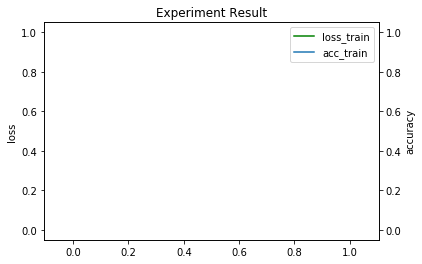

In [24]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


/home/dana/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the network on the 10000 test images: 10 %


In [26]:
class LocalUpdate(object):
    def __init__(self, lr,local_epoch,device,batch_size, dataset=None, idxs=None,alpha=10):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)
        self.alpha=alpha

    def train(self, net):
        net.sync_online_and_global()
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.lr)

        epoch_loss = []
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs,activation_l2 = net(images,online_target=True)
                loss = self.loss_func(log_probs, labels)+self.alpha*activation_l2
                loss.backward()
                optimizer.step()
                #if batch_idx % 10 == 0:
                #    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                #               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

cifar10 FedAvg iid로 학습

In [27]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=0

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


In [28]:
weight_saved=FedAvg_model.state_dict()

In [29]:
C=0.05
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [30]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

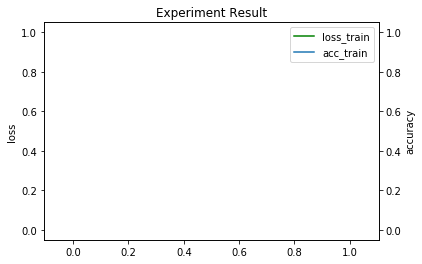

In [31]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [32]:
PATH = './data/CIFAR_iid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

cifar10 FedAvg Non-iid로 학습


In [33]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=5001

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


In [34]:
weight_saved=FedAvg_model.state_dict()

In [35]:
C=0.05
num_clients=100
CIFAR_noniid_dataset=cifar_dirichlet(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

torch.int64


In [36]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 2.286
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
 Average loss 2.263
Accuracy of the network on the 10000 test images: 10.220000 %
This is global 2 epoch
 Average loss 2.275
Accuracy of the network on the 10000 test images: 11.790000 %
This is global 3 epoch
 Average loss 2.289
Accuracy of the network on the 10000 test images: 10.360000 %
This is global 4 epoch
 Average loss 2.260
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 5 epoch
 Average loss 2.263
Accuracy of the network on the 10000 test images: 15.290000 %
This is global 6 epoch
 Average loss 2.273
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 7 epoch
 Average loss 2.263
Accuracy of the network on the 10000 test images: 12.600000 %
This is global 8 epoch
 Average loss 2.266
Accuracy of the network on the 10000 test images: 15.140000 %
This is global 9 epoch
 Average loss 2.260
Accuracy of the network on the 1000

 Average loss 2.003
Accuracy of the network on the 10000 test images: 35.280000 %
This is global 79 epoch
 Average loss 2.010
Accuracy of the network on the 10000 test images: 35.960000 %
This is global 80 epoch
 Average loss 2.055
Accuracy of the network on the 10000 test images: 34.410000 %
This is global 81 epoch
 Average loss 2.029
Accuracy of the network on the 10000 test images: 34.840000 %
This is global 82 epoch
 Average loss 2.024
Accuracy of the network on the 10000 test images: 35.350000 %
This is global 83 epoch
 Average loss 1.968
Accuracy of the network on the 10000 test images: 35.300000 %
This is global 84 epoch
 Average loss 2.028
Accuracy of the network on the 10000 test images: 35.020000 %
This is global 85 epoch
 Average loss 2.027
Accuracy of the network on the 10000 test images: 35.530000 %
This is global 86 epoch
 Average loss 2.032
Accuracy of the network on the 10000 test images: 35.890000 %
This is global 87 epoch
 Average loss 2.024
Accuracy of the network on

 Average loss 1.990
Accuracy of the network on the 10000 test images: 43.020000 %
This is global 156 epoch
 Average loss 1.831
Accuracy of the network on the 10000 test images: 42.810000 %
This is global 157 epoch
 Average loss 1.868
Accuracy of the network on the 10000 test images: 41.660000 %
This is global 158 epoch
 Average loss 1.881
Accuracy of the network on the 10000 test images: 40.640000 %
This is global 159 epoch
 Average loss 1.906
Accuracy of the network on the 10000 test images: 41.110000 %
This is global 160 epoch
 Average loss 1.926
Accuracy of the network on the 10000 test images: 41.750000 %
This is global 161 epoch
 Average loss 1.930
Accuracy of the network on the 10000 test images: 40.160000 %
This is global 162 epoch
 Average loss 1.977
Accuracy of the network on the 10000 test images: 39.360000 %
This is global 163 epoch
 Average loss 2.011
Accuracy of the network on the 10000 test images: 40.340000 %
This is global 164 epoch
 Average loss 1.857
Accuracy of the n

 Average loss 1.703
Accuracy of the network on the 10000 test images: 47.940000 %
This is global 233 epoch
 Average loss 1.732
Accuracy of the network on the 10000 test images: 47.420000 %
This is global 234 epoch
 Average loss 1.712
Accuracy of the network on the 10000 test images: 47.360000 %
This is global 235 epoch
 Average loss 1.826
Accuracy of the network on the 10000 test images: 46.590000 %
This is global 236 epoch
 Average loss 2.190
Accuracy of the network on the 10000 test images: 46.260000 %
This is global 237 epoch
 Average loss 1.789
Accuracy of the network on the 10000 test images: 47.470000 %
This is global 238 epoch
 Average loss 1.813
Accuracy of the network on the 10000 test images: 47.350000 %
This is global 239 epoch
 Average loss 1.722
Accuracy of the network on the 10000 test images: 47.470000 %
This is global 240 epoch
 Average loss 1.788
Accuracy of the network on the 10000 test images: 47.390000 %
This is global 241 epoch
 Average loss 1.736
Accuracy of the n

 Average loss 1.734
Accuracy of the network on the 10000 test images: 49.740000 %
This is global 310 epoch
 Average loss 1.573
Accuracy of the network on the 10000 test images: 49.810000 %
This is global 311 epoch
 Average loss 1.705
Accuracy of the network on the 10000 test images: 48.870000 %
This is global 312 epoch
 Average loss 1.696
Accuracy of the network on the 10000 test images: 49.160000 %
This is global 313 epoch
 Average loss 1.739
Accuracy of the network on the 10000 test images: 48.060000 %
This is global 314 epoch
 Average loss 1.810
Accuracy of the network on the 10000 test images: 48.340000 %
This is global 315 epoch
 Average loss 1.742
Accuracy of the network on the 10000 test images: 48.010000 %
This is global 316 epoch
 Average loss 1.665
Accuracy of the network on the 10000 test images: 49.100000 %
This is global 317 epoch
 Average loss 1.651
Accuracy of the network on the 10000 test images: 48.790000 %
This is global 318 epoch
 Average loss 1.709
Accuracy of the n

 Average loss 1.653
Accuracy of the network on the 10000 test images: 50.720000 %
This is global 387 epoch
 Average loss 1.479
Accuracy of the network on the 10000 test images: 50.790000 %
This is global 388 epoch
 Average loss 1.787
Accuracy of the network on the 10000 test images: 51.610000 %
This is global 389 epoch
 Average loss 1.490
Accuracy of the network on the 10000 test images: 52.530000 %
This is global 390 epoch
 Average loss 1.682
Accuracy of the network on the 10000 test images: 51.770000 %
This is global 391 epoch
 Average loss 1.644
Accuracy of the network on the 10000 test images: 51.590000 %
This is global 392 epoch
 Average loss 1.524
Accuracy of the network on the 10000 test images: 52.300000 %
This is global 393 epoch
 Average loss 1.637
Accuracy of the network on the 10000 test images: 52.170000 %
This is global 394 epoch
 Average loss 1.444
Accuracy of the network on the 10000 test images: 52.320000 %
This is global 395 epoch
 Average loss 1.513
Accuracy of the n

 Average loss 1.414
Accuracy of the network on the 10000 test images: 53.720000 %
This is global 464 epoch
 Average loss 1.657
Accuracy of the network on the 10000 test images: 53.740000 %
This is global 465 epoch
 Average loss 1.408
Accuracy of the network on the 10000 test images: 54.380000 %
This is global 466 epoch
 Average loss 1.673
Accuracy of the network on the 10000 test images: 53.480000 %
This is global 467 epoch
 Average loss 1.501
Accuracy of the network on the 10000 test images: 52.970000 %
This is global 468 epoch
 Average loss 1.607
Accuracy of the network on the 10000 test images: 54.310000 %
This is global 469 epoch
 Average loss 1.592
Accuracy of the network on the 10000 test images: 53.950000 %
This is global 470 epoch
 Average loss 1.450
Accuracy of the network on the 10000 test images: 52.610000 %
This is global 471 epoch
 Average loss 1.492
Accuracy of the network on the 10000 test images: 53.050000 %
This is global 472 epoch
 Average loss 1.473
Accuracy of the n

 Average loss 1.773
Accuracy of the network on the 10000 test images: 55.820000 %
This is global 541 epoch
 Average loss 1.661
Accuracy of the network on the 10000 test images: 56.250000 %
This is global 542 epoch
 Average loss 1.378
Accuracy of the network on the 10000 test images: 56.390000 %
This is global 543 epoch
 Average loss 1.501
Accuracy of the network on the 10000 test images: 56.100000 %
This is global 544 epoch
 Average loss 1.449
Accuracy of the network on the 10000 test images: 56.730000 %
This is global 545 epoch
 Average loss 1.340
Accuracy of the network on the 10000 test images: 56.250000 %
This is global 546 epoch
 Average loss 1.438
Accuracy of the network on the 10000 test images: 56.240000 %
This is global 547 epoch
 Average loss 1.414
Accuracy of the network on the 10000 test images: 56.850000 %
This is global 548 epoch
 Average loss 1.714
Accuracy of the network on the 10000 test images: 57.280000 %
This is global 549 epoch
 Average loss 1.415
Accuracy of the n

 Average loss 1.481
Accuracy of the network on the 10000 test images: 56.060000 %
This is global 618 epoch
 Average loss 1.439
Accuracy of the network on the 10000 test images: 55.760000 %
This is global 619 epoch
 Average loss 1.514
Accuracy of the network on the 10000 test images: 55.460000 %
This is global 620 epoch
 Average loss 1.366
Accuracy of the network on the 10000 test images: 54.850000 %
This is global 621 epoch
 Average loss 1.562
Accuracy of the network on the 10000 test images: 54.480000 %
This is global 622 epoch
 Average loss 1.805
Accuracy of the network on the 10000 test images: 55.450000 %
This is global 623 epoch
 Average loss 1.358
Accuracy of the network on the 10000 test images: 54.420000 %
This is global 624 epoch
 Average loss 1.573
Accuracy of the network on the 10000 test images: 55.490000 %
This is global 625 epoch
 Average loss 1.328
Accuracy of the network on the 10000 test images: 55.550000 %
This is global 626 epoch
 Average loss 1.416
Accuracy of the n

 Average loss 1.300
Accuracy of the network on the 10000 test images: 56.570000 %
This is global 695 epoch
 Average loss 1.287
Accuracy of the network on the 10000 test images: 56.570000 %
This is global 696 epoch
 Average loss 1.590
Accuracy of the network on the 10000 test images: 56.870000 %
This is global 697 epoch
 Average loss 1.342
Accuracy of the network on the 10000 test images: 57.680000 %
This is global 698 epoch
 Average loss 1.318
Accuracy of the network on the 10000 test images: 57.780000 %
This is global 699 epoch
 Average loss 1.333
Accuracy of the network on the 10000 test images: 57.230000 %
This is global 700 epoch
 Average loss 1.753
Accuracy of the network on the 10000 test images: 57.430000 %
This is global 701 epoch
 Average loss 1.404
Accuracy of the network on the 10000 test images: 58.440000 %
This is global 702 epoch
 Average loss 1.258
Accuracy of the network on the 10000 test images: 56.920000 %
This is global 703 epoch
 Average loss 1.532
Accuracy of the n

 Average loss 1.326
Accuracy of the network on the 10000 test images: 57.500000 %
This is global 772 epoch
 Average loss 1.684
Accuracy of the network on the 10000 test images: 57.450000 %
This is global 773 epoch
 Average loss 1.282
Accuracy of the network on the 10000 test images: 57.730000 %
This is global 774 epoch
 Average loss 1.454
Accuracy of the network on the 10000 test images: 57.770000 %
This is global 775 epoch
 Average loss 1.378
Accuracy of the network on the 10000 test images: 57.130000 %
This is global 776 epoch
 Average loss 1.602
Accuracy of the network on the 10000 test images: 57.550000 %
This is global 777 epoch
 Average loss 1.388
Accuracy of the network on the 10000 test images: 57.540000 %
This is global 778 epoch
 Average loss 1.324
Accuracy of the network on the 10000 test images: 57.620000 %
This is global 779 epoch
 Average loss 1.296
Accuracy of the network on the 10000 test images: 57.920000 %
This is global 780 epoch
 Average loss 1.472
Accuracy of the n

 Average loss 1.252
Accuracy of the network on the 10000 test images: 59.130000 %
This is global 849 epoch
 Average loss 1.282
Accuracy of the network on the 10000 test images: 59.590000 %
This is global 850 epoch
 Average loss 1.308
Accuracy of the network on the 10000 test images: 59.900000 %
This is global 851 epoch
 Average loss 1.759
Accuracy of the network on the 10000 test images: 59.950000 %
This is global 852 epoch
 Average loss 1.323
Accuracy of the network on the 10000 test images: 59.900000 %
This is global 853 epoch
 Average loss 1.262
Accuracy of the network on the 10000 test images: 59.900000 %
This is global 854 epoch
 Average loss 1.300
Accuracy of the network on the 10000 test images: 59.490000 %
This is global 855 epoch
 Average loss 1.670
Accuracy of the network on the 10000 test images: 58.940000 %
This is global 856 epoch
 Average loss 1.510
Accuracy of the network on the 10000 test images: 58.840000 %
This is global 857 epoch
 Average loss 1.624
Accuracy of the n

 Average loss 1.298
Accuracy of the network on the 10000 test images: 59.570000 %
This is global 926 epoch
 Average loss 1.327
Accuracy of the network on the 10000 test images: 59.050000 %
This is global 927 epoch
 Average loss 1.492
Accuracy of the network on the 10000 test images: 58.810000 %
This is global 928 epoch
 Average loss 1.227
Accuracy of the network on the 10000 test images: 59.520000 %
This is global 929 epoch
 Average loss 1.124
Accuracy of the network on the 10000 test images: 59.910000 %
This is global 930 epoch
 Average loss 1.419
Accuracy of the network on the 10000 test images: 59.790000 %
This is global 931 epoch
 Average loss 1.271
Accuracy of the network on the 10000 test images: 59.950000 %
This is global 932 epoch
 Average loss 1.191
Accuracy of the network on the 10000 test images: 60.430000 %
This is global 933 epoch
 Average loss 1.355
Accuracy of the network on the 10000 test images: 60.350000 %
This is global 934 epoch
 Average loss 1.276
Accuracy of the n

 Average loss 1.432
Accuracy of the network on the 10000 test images: 60.360000 %
This is global 1003 epoch
 Average loss 1.176
Accuracy of the network on the 10000 test images: 60.140000 %
This is global 1004 epoch
 Average loss 1.221
Accuracy of the network on the 10000 test images: 60.360000 %
This is global 1005 epoch
 Average loss 1.579
Accuracy of the network on the 10000 test images: 60.010000 %
This is global 1006 epoch
 Average loss 1.337
Accuracy of the network on the 10000 test images: 60.030000 %
This is global 1007 epoch
 Average loss 1.231
Accuracy of the network on the 10000 test images: 60.280000 %
This is global 1008 epoch
 Average loss 1.686
Accuracy of the network on the 10000 test images: 60.520000 %
This is global 1009 epoch
 Average loss 1.286
Accuracy of the network on the 10000 test images: 60.380000 %
This is global 1010 epoch
 Average loss 1.169
Accuracy of the network on the 10000 test images: 60.450000 %
This is global 1011 epoch
 Average loss 1.368
Accuracy

 Average loss 1.143
Accuracy of the network on the 10000 test images: 59.180000 %
This is global 1079 epoch
 Average loss 1.509
Accuracy of the network on the 10000 test images: 60.030000 %
This is global 1080 epoch
 Average loss 1.198
Accuracy of the network on the 10000 test images: 60.100000 %
This is global 1081 epoch
 Average loss 1.351
Accuracy of the network on the 10000 test images: 60.020000 %
This is global 1082 epoch
 Average loss 1.217
Accuracy of the network on the 10000 test images: 60.040000 %
This is global 1083 epoch
 Average loss 1.361
Accuracy of the network on the 10000 test images: 59.670000 %
This is global 1084 epoch
 Average loss 1.069
Accuracy of the network on the 10000 test images: 59.800000 %
This is global 1085 epoch
 Average loss 1.236
Accuracy of the network on the 10000 test images: 60.230000 %
This is global 1086 epoch
 Average loss 1.169
Accuracy of the network on the 10000 test images: 60.470000 %
This is global 1087 epoch
 Average loss 1.422
Accuracy

 Average loss 1.072
Accuracy of the network on the 10000 test images: 60.410000 %
This is global 1155 epoch
 Average loss 1.268
Accuracy of the network on the 10000 test images: 60.350000 %
This is global 1156 epoch
 Average loss 1.393
Accuracy of the network on the 10000 test images: 60.350000 %
This is global 1157 epoch
 Average loss 1.462
Accuracy of the network on the 10000 test images: 60.060000 %
This is global 1158 epoch
 Average loss 1.362
Accuracy of the network on the 10000 test images: 59.990000 %
This is global 1159 epoch
 Average loss 1.084
Accuracy of the network on the 10000 test images: 60.420000 %
This is global 1160 epoch
 Average loss 1.160
Accuracy of the network on the 10000 test images: 61.050000 %
This is global 1161 epoch
 Average loss 1.280
Accuracy of the network on the 10000 test images: 60.830000 %
This is global 1162 epoch
 Average loss 1.017
Accuracy of the network on the 10000 test images: 60.910000 %
This is global 1163 epoch
 Average loss 1.072
Accuracy

 Average loss 1.788
Accuracy of the network on the 10000 test images: 58.920000 %
This is global 1231 epoch
 Average loss 1.126
Accuracy of the network on the 10000 test images: 58.980000 %
This is global 1232 epoch
 Average loss 1.092
Accuracy of the network on the 10000 test images: 58.490000 %
This is global 1233 epoch
 Average loss 1.660
Accuracy of the network on the 10000 test images: 58.540000 %
This is global 1234 epoch
 Average loss 1.127
Accuracy of the network on the 10000 test images: 58.720000 %
This is global 1235 epoch
 Average loss 1.397
Accuracy of the network on the 10000 test images: 59.190000 %
This is global 1236 epoch
 Average loss 1.232
Accuracy of the network on the 10000 test images: 59.290000 %
This is global 1237 epoch
 Average loss 1.416
Accuracy of the network on the 10000 test images: 58.720000 %
This is global 1238 epoch
 Average loss 1.178
Accuracy of the network on the 10000 test images: 59.000000 %
This is global 1239 epoch
 Average loss 1.581
Accuracy

 Average loss 1.219
Accuracy of the network on the 10000 test images: 59.170000 %
This is global 1307 epoch
 Average loss 1.207
Accuracy of the network on the 10000 test images: 59.400000 %
This is global 1308 epoch
 Average loss 1.393
Accuracy of the network on the 10000 test images: 59.580000 %
This is global 1309 epoch
 Average loss 1.240
Accuracy of the network on the 10000 test images: 59.470000 %
This is global 1310 epoch
 Average loss 1.273
Accuracy of the network on the 10000 test images: 59.640000 %
This is global 1311 epoch
 Average loss 1.202
Accuracy of the network on the 10000 test images: 59.720000 %
This is global 1312 epoch
 Average loss 1.235
Accuracy of the network on the 10000 test images: 59.550000 %
This is global 1313 epoch
 Average loss 1.290
Accuracy of the network on the 10000 test images: 60.590000 %
This is global 1314 epoch
 Average loss 1.255
Accuracy of the network on the 10000 test images: 61.030000 %
This is global 1315 epoch
 Average loss 1.118
Accuracy

 Average loss 1.214
Accuracy of the network on the 10000 test images: 59.740000 %
This is global 1383 epoch
 Average loss 2.012
Accuracy of the network on the 10000 test images: 58.720000 %
This is global 1384 epoch
 Average loss 1.342
Accuracy of the network on the 10000 test images: 58.500000 %
This is global 1385 epoch
 Average loss 1.085
Accuracy of the network on the 10000 test images: 58.620000 %
This is global 1386 epoch
 Average loss 1.091
Accuracy of the network on the 10000 test images: 58.880000 %
This is global 1387 epoch
 Average loss 1.384
Accuracy of the network on the 10000 test images: 58.840000 %
This is global 1388 epoch
 Average loss 1.344
Accuracy of the network on the 10000 test images: 58.590000 %
This is global 1389 epoch
 Average loss 1.132
Accuracy of the network on the 10000 test images: 59.560000 %
This is global 1390 epoch
 Average loss 1.262
Accuracy of the network on the 10000 test images: 59.850000 %
This is global 1391 epoch
 Average loss 1.197
Accuracy

 Average loss 1.119
Accuracy of the network on the 10000 test images: 59.920000 %
This is global 1459 epoch
 Average loss 1.101
Accuracy of the network on the 10000 test images: 59.800000 %
This is global 1460 epoch
 Average loss 1.404
Accuracy of the network on the 10000 test images: 59.920000 %
This is global 1461 epoch
 Average loss 1.499
Accuracy of the network on the 10000 test images: 59.850000 %
This is global 1462 epoch
 Average loss 1.189
Accuracy of the network on the 10000 test images: 59.530000 %
This is global 1463 epoch
 Average loss 1.299
Accuracy of the network on the 10000 test images: 59.080000 %
This is global 1464 epoch
 Average loss 1.097
Accuracy of the network on the 10000 test images: 59.560000 %
This is global 1465 epoch
 Average loss 1.217
Accuracy of the network on the 10000 test images: 59.700000 %
This is global 1466 epoch
 Average loss 1.320
Accuracy of the network on the 10000 test images: 59.260000 %
This is global 1467 epoch
 Average loss 1.076
Accuracy

 Average loss 1.094
Accuracy of the network on the 10000 test images: 61.230000 %
This is global 1535 epoch
 Average loss 1.117
Accuracy of the network on the 10000 test images: 61.350000 %
This is global 1536 epoch
 Average loss 1.435
Accuracy of the network on the 10000 test images: 61.080000 %
This is global 1537 epoch
 Average loss 1.112
Accuracy of the network on the 10000 test images: 60.900000 %
This is global 1538 epoch
 Average loss 1.085
Accuracy of the network on the 10000 test images: 60.980000 %
This is global 1539 epoch
 Average loss 1.118
Accuracy of the network on the 10000 test images: 61.320000 %
This is global 1540 epoch
 Average loss 1.030
Accuracy of the network on the 10000 test images: 61.240000 %
This is global 1541 epoch
 Average loss 1.152
Accuracy of the network on the 10000 test images: 60.680000 %
This is global 1542 epoch
 Average loss 1.333
Accuracy of the network on the 10000 test images: 60.730000 %
This is global 1543 epoch
 Average loss 1.705
Accuracy

 Average loss 1.394
Accuracy of the network on the 10000 test images: 59.070000 %
This is global 1611 epoch
 Average loss 1.551
Accuracy of the network on the 10000 test images: 59.340000 %
This is global 1612 epoch
 Average loss 1.143
Accuracy of the network on the 10000 test images: 59.720000 %
This is global 1613 epoch
 Average loss 1.474
Accuracy of the network on the 10000 test images: 59.600000 %
This is global 1614 epoch
 Average loss 1.241
Accuracy of the network on the 10000 test images: 60.290000 %
This is global 1615 epoch
 Average loss 1.835
Accuracy of the network on the 10000 test images: 59.270000 %
This is global 1616 epoch
 Average loss 1.144
Accuracy of the network on the 10000 test images: 59.270000 %
This is global 1617 epoch
 Average loss 1.002
Accuracy of the network on the 10000 test images: 59.540000 %
This is global 1618 epoch
 Average loss 1.196
Accuracy of the network on the 10000 test images: 59.380000 %
This is global 1619 epoch
 Average loss 1.080
Accuracy

 Average loss 1.186
Accuracy of the network on the 10000 test images: 60.660000 %
This is global 1687 epoch
 Average loss 1.250
Accuracy of the network on the 10000 test images: 59.950000 %
This is global 1688 epoch
 Average loss 1.261
Accuracy of the network on the 10000 test images: 59.670000 %
This is global 1689 epoch
 Average loss 1.297
Accuracy of the network on the 10000 test images: 59.570000 %
This is global 1690 epoch
 Average loss 1.131
Accuracy of the network on the 10000 test images: 59.730000 %
This is global 1691 epoch
 Average loss 1.211
Accuracy of the network on the 10000 test images: 59.570000 %
This is global 1692 epoch
 Average loss 1.047
Accuracy of the network on the 10000 test images: 59.960000 %
This is global 1693 epoch
 Average loss 1.257
Accuracy of the network on the 10000 test images: 60.630000 %
This is global 1694 epoch
 Average loss 1.697
Accuracy of the network on the 10000 test images: 60.020000 %
This is global 1695 epoch
 Average loss 1.018
Accuracy

 Average loss 0.952
Accuracy of the network on the 10000 test images: 59.720000 %
This is global 1763 epoch
 Average loss 1.337
Accuracy of the network on the 10000 test images: 59.200000 %
This is global 1764 epoch
 Average loss 1.203
Accuracy of the network on the 10000 test images: 59.200000 %
This is global 1765 epoch
 Average loss 1.087
Accuracy of the network on the 10000 test images: 59.210000 %
This is global 1766 epoch
 Average loss 2.024
Accuracy of the network on the 10000 test images: 58.710000 %
This is global 1767 epoch
 Average loss 1.171
Accuracy of the network on the 10000 test images: 58.580000 %
This is global 1768 epoch
 Average loss 1.285
Accuracy of the network on the 10000 test images: 58.410000 %
This is global 1769 epoch
 Average loss 1.339
Accuracy of the network on the 10000 test images: 58.940000 %
This is global 1770 epoch
 Average loss 1.104
Accuracy of the network on the 10000 test images: 59.040000 %
This is global 1771 epoch
 Average loss 1.216
Accuracy

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1840 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1841 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1842 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1843 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1844 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1845 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1846 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1847 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1848 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1918 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1919 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1920 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1921 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1922 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1923 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1924 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1925 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1926 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1996 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1997 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1998 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1999 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2000 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2001 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2002 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2003 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2004 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2074 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2075 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2076 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2077 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2078 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2079 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2080 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2081 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2082 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2152 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2153 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2154 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2155 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2156 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2157 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2158 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2159 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2160 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2230 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2231 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2232 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2233 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2234 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2235 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2236 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2237 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2238 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2308 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2309 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2310 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2311 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2312 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2313 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2314 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2315 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2316 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2386 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2387 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2388 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2389 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2390 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2391 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2392 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2393 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2394 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2464 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2465 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2466 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2467 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2468 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2469 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2470 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2471 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2472 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2542 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2543 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2544 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2545 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2546 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2547 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2548 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2549 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2550 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2620 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2621 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2622 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2623 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2624 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2625 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2626 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2627 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2628 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2698 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2699 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2700 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2701 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2702 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2703 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2704 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2705 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2706 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2776 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2777 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2778 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2779 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2780 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2781 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2782 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2783 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2784 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2854 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2855 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2856 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2857 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2858 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2859 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2860 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2861 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2862 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2932 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2933 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2934 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2935 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2936 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2937 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2938 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2939 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2940 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3010 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3011 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3012 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3013 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3014 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3015 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3016 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3017 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3018 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3088 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3089 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3090 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3091 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3092 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3093 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3094 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3095 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3096 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3166 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3167 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3168 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3169 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3170 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3171 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3172 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3173 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3174 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3244 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3245 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3246 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3247 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3248 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3249 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3250 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3251 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3252 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3322 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3323 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3324 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3325 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3326 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3327 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3328 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3329 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3330 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3400 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3401 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3402 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3403 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3404 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3405 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3406 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3407 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3408 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3478 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3479 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3480 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3481 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3482 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3483 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3484 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3485 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3486 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3556 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3557 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3558 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3559 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3560 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3561 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3562 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3563 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3564 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3634 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3635 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3636 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3637 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3638 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3639 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3640 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3641 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3642 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3712 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3713 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3714 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3715 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3716 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3717 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3718 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3719 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3720 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3790 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3791 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3792 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3793 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3794 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3795 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3796 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3797 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3798 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3868 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3869 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3870 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3871 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3872 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3873 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3874 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3875 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3876 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3946 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3947 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3948 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3949 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3950 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3951 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3952 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3953 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3954 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4024 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4025 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4026 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4027 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4028 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4029 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4030 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4031 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4032 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4102 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4103 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4104 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4105 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4106 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4107 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4108 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4109 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4110 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4180 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4181 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4182 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4183 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4184 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4185 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4186 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4187 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4188 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4258 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4259 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4260 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4261 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4262 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4263 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4264 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4265 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4266 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4336 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4337 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4338 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4339 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4340 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4341 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4342 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4343 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4344 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4414 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4415 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4416 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4417 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4418 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4419 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4420 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4421 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4422 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4492 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4493 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4494 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4495 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4496 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4497 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4498 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4499 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4500 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4570 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4571 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4572 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4573 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4574 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4575 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4576 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4577 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4578 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4648 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4649 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4650 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4651 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4652 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4653 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4654 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4655 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4656 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4726 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4727 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4728 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4729 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4730 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4731 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4732 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4733 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4734 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4804 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4805 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4806 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4807 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4808 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4809 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4810 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4811 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4812 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4882 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4883 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4884 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4885 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4886 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4887 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4888 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4889 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4890 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4960 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4961 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4962 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4963 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4964 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4965 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4966 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4967 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4968 epoch
 Average loss nan
Accuracy of the network on t

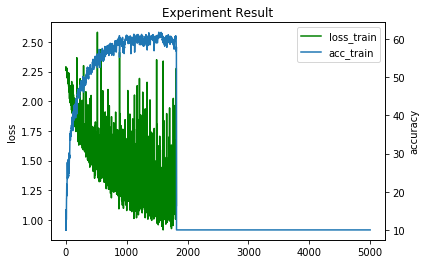

In [37]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [38]:
PATH = './data/CIFAR_noniid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

In [39]:
print(max(acc_train))

61.78
